In [12]:
import os
import pandas as pd
import torch
from torch.utils.data import Dataset
from skimage import io

import torchvision.transforms as T
from PIL import Image
from torchvision.utils import make_grid
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot  as plt
import torchvision
from torch.autograd import Variable
import torch.nn as nn

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [3]:
transformer = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((256,256)),
    transforms.Normalize([0.5, 0.5, 0.5] , [0.5, 0.5, 0.5])
])

In [116]:
class LPDataset(Dataset):
    def __init__(self, csv_file, root_dir):
        self.annotations = pd.read_csv(csv_file)
        self.root_dir = root_dir
        
    def __len__(self):
        return len(self.annotations)
    
    def __getitem__(self, index):
        Blur_image_path = os.path.join(self.root_dir, self.annotations.iloc[index, 0])
        image = io.imread(Blur_image_path)
        image = transformer(image)
        Main_image_path = os.path.join("DATA", "Main_image", self.annotations.iloc[index, 1])
        T_image = io.imread(Main_image_path)
        T_image = transformer(T_image)
        return (image, T_image)
    

In [120]:
dataset = LPDataset(csv_file='DATA_03.csv', root_dir='DATA/Blur')

In [128]:
train_dataloader = DataLoader(
    dataset,
    batch_size = 32,
    shuffle= True
)

torch.Size([32, 3, 256, 256]) torch.Size([32, 3, 256, 256])


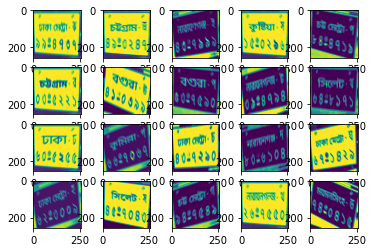

188


In [129]:
example = iter(train_dataloader)
image, T_image = example.next()
print(image.shape, T_image.shape)
for i in range(20):
    plt.subplot(4,5, i+1)
    plt.imshow(image[i][0])
plt.show()
print(len(train_dataloader))

In [57]:
class Autoencoder_2(torch.nn.Module):
    def __init__(self):
        super().__init__()        
        # N, 3, 256, 256
        self.encoder = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=3, out_channels=16, kernel_size= 4, stride=2, padding=0), # -> N, 16, 128, 128
            torch.nn.ReLU(),
            
            torch.nn.Conv2d(in_channels= 16, out_channels= 32, kernel_size=4, stride=2, padding=0), # -> N, 32, 64, 64
            torch.nn.ReLU(),
            
            torch.nn.Conv2d(in_channels= 32, out_channels= 64, kernel_size=4, stride=2, padding=0), # -> N, 64, 32, 32
            torch.nn.ReLU(),
            
            torch.nn.Conv2d(in_channels= 64, out_channels= 128, kernel_size=4, stride=2, padding=0), # -> N, 128, 16, 16
            torch.nn.ReLU(),
            
            torch.nn.Conv2d(in_channels= 128, out_channels= 256, kernel_size=4, stride=2, padding=0), # -> N, 256, 8, 8  
            torch.nn.ReLU(),
            
            torch.nn.Conv2d(in_channels= 256, out_channels= 512, kernel_size=8, stride=8, padding=0), # -> N, 512, 1, 1  
            
            
#             torch.nn.Conv2d(3, 16, 3, stride=2, padding=1), # -> N, 16, 14, 14
#             torch.nn.ReLU(),
#             torch.nn.Conv2d(16, 32, 3, stride=2, padding=1), # -> N, 32, 7, 7
#             torch.nn.ReLU(),
#             torch.nn.Conv2d(32, 64, 7) # -> N, 64, 1, 1
        )
        
        # N, 512, 1, 1
        self.decoder = torch.nn.Sequential(
            
            torch.nn.ConvTranspose2d(in_channels= 512,out_channels= 256, kernel_size=8, stride=8, padding=0), # -> N, 256, 8, 8
            torch.nn.ReLU(),
            
            torch.nn.ConvTranspose2d(in_channels= 256,out_channels= 128, kernel_size=4, stride=2, padding=0, output_padding=1), # -> N, 128, 16, 16
            torch.nn.ReLU(),
            
            torch.nn.ConvTranspose2d(in_channels= 128,out_channels= 64, kernel_size=3, stride=2, padding=1, output_padding=1), # -> N, 32, 7, 7
            torch.nn.ReLU(),
            
            torch.nn.ConvTranspose2d(in_channels= 64,out_channels= 32, kernel_size=5, stride=2, padding=1, output_padding=1), # -> N, 32, 7, 7
            torch.nn.ReLU(),
            
            torch.nn.ConvTranspose2d(in_channels= 32,out_channels= 16, kernel_size= 3, stride=2, padding=1, output_padding=1), # -> N, 32, 7, 7
            torch.nn.ReLU(),
            
            torch.nn.ConvTranspose2d(in_channels= 16,out_channels= 3, kernel_size= 3, stride=2, padding=1, output_padding=1), # -> N, 32, 7, 7
            
#             torch.nn.ConvTranspose2d(64, 32, 7), # -> N, 32, 7, 7
#             torch.nn.ReLU(),
#             torch.nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1), # N, 16, 14, 14 (N,16,13,13 without output_padding)
#             torch.nn.ReLU(),
#             torch.nn.ConvTranspose2d(16, 3, 3, stride=2, padding=1, output_padding=1), # N, 1, 28, 28  (N,1,27,27)
            torch.nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
    

In [60]:
class Autoencoder_03(torch.nn.Module):
    def __init__(self):
        super().__init__()        
        
        self.encoder = torch.nn.Sequential(
            nn.Conv2d(3, 6, 4, stride=2),
            nn.ReLU(),
            nn.Conv2d(6, 12, 4, stride=2),
            nn.ReLU(),
            nn.Conv2d(12, 24, 4, stride=2),
            nn.ReLU(),
            nn.Conv2d(24, 48, 4, stride=2),
            nn.ReLU(),
            nn.Conv2d(48, 96, 4, stride=2),
            nn.ReLU(),
            nn.Conv2d(96, 512, 4, stride=2)
            
        )
        
        
        self.decoder = torch.nn.Sequential(
            nn.ConvTranspose2d(512, 96, 4, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(96, 48, 4, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(48, 24, 4, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(24, 12, 4, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(12, 6, 4, stride=2,output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(6, 3, 4, stride=2),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [ ]:
class Autoencoder(torch.nn.Module):
    def __init__(self):
        super().__init__()        
        # N, 1, 28, 28
        self.encoder = torch.nn.Sequential(
            torch.nn.Conv2d(3, 16, 3, stride=2, padding=1), # -> N, 16, 14, 14
            torch.nn.ReLU(),
            torch.nn.Conv2d(16, 32, 3, stride=2, padding=1), # -> N, 32, 7, 7
            torch.nn.ReLU(),
           torch. nn.Conv2d(32, 64, 7) # -> N, 64, 1, 1
        )
        
        # N , 64, 1, 1
        self.decoder = torch.nn.Sequential(
            torch.nn.ConvTranspose2d(64, 32, 7), # -> N, 32, 7, 7
            torch.nn.ReLU(),
            torch.nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1), # N, 16, 14, 14 (N,16,13,13 without output_padding)
            torch.nn.ReLU(),
            torch.nn.ConvTranspose2d(16, 3, 3, stride=2, padding=1, output_padding=1), # N, 1, 28, 28  (N,1,27,27)
            torch.nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [61]:
model = Autoencoder_03()
model = model.to(device)

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [123]:
num_epochs = 100
outputs = []
for epoch in range(num_epochs):
    model.train()
    for (_, [image, T_image]) in enumerate(train_dataloader):
        print(T_image[0])
#         plt.imshow(image[19].permute(1, 2, 0))
#         plt.show()
#         plt.imshow(T_image[19].permute(1, 2, 0))
#         plt.show()
        image = image.to(device)
        T_image = T_image.to(device)
        # img = img.reshape(-1, 28*28) # -> use for Autoencoder_Linear
        
#         for i in range(20):
        recon = model(image)
        loss = criterion(recon, T_image)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch:{epoch+1}, Loss:{loss.item():.4f}')
    

Epoch:1, Loss:0.5217
Epoch:2, Loss:0.4136
Epoch:3, Loss:0.4022
Epoch:4, Loss:0.4039
Epoch:5, Loss:0.3926
Epoch:6, Loss:0.3491
Epoch:7, Loss:0.4664
Epoch:8, Loss:0.3741
Epoch:9, Loss:0.3100
Epoch:10, Loss:0.4195
Epoch:11, Loss:0.4243
Epoch:12, Loss:0.4436
Epoch:13, Loss:0.5867
Epoch:14, Loss:0.3769
Epoch:15, Loss:0.2846
Epoch:16, Loss:0.3245
Epoch:17, Loss:0.2236
Epoch:18, Loss:0.2338
Epoch:19, Loss:0.4560
Epoch:20, Loss:0.1911
Epoch:21, Loss:0.2065
Epoch:22, Loss:0.4126
Epoch:23, Loss:0.6209
Epoch:24, Loss:0.4221
Epoch:25, Loss:0.3335
Epoch:26, Loss:0.2235
Epoch:27, Loss:0.2975
Epoch:28, Loss:0.4571
Epoch:29, Loss:0.4263
Epoch:30, Loss:0.1729
Epoch:31, Loss:0.5584
Epoch:32, Loss:0.4598
Epoch:33, Loss:0.4074
Epoch:34, Loss:0.3085
Epoch:35, Loss:0.3663
Epoch:36, Loss:0.3342
Epoch:37, Loss:0.3193
Epoch:38, Loss:0.3083
Epoch:39, Loss:0.2810
Epoch:40, Loss:0.3182
Epoch:41, Loss:0.1486
Epoch:42, Loss:0.5191
Epoch:43, Loss:0.3181
Epoch:44, Loss:0.3120
Epoch:45, Loss:0.3750
Epoch:46, Loss:0.29

In [32]:
def PredictionCNN(image_path , transformer):
    image = Image.open(image_path)
    plt.imshow(image)
    plt.show()
    image_tensor = transformer(image).float()
    image_tensor = image_tensor.unsqueeze_(0)
    image_tensor.to(device)
       
        
    input = Variable(image_tensor).to(device)

    output = model(input)
    output = output.cpu()
    
    
    plt.imshow(output[0].permute(1, 2, 0).detach().numpy())
    plt.show()
    
    return output.size()

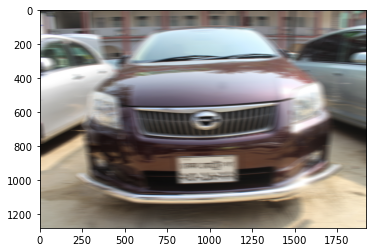

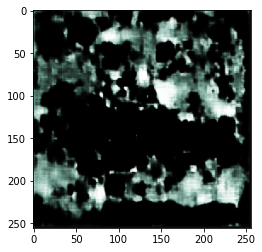

torch.Size([1, 3, 256, 256])

In [127]:
PredictionCNN("G:/CSE_499a/jupyter/DeBlur/try01/sample3.jpg", transformer)